 03_model_diagnostics.ipynb
 --------------------------
 Purpose:
 - This notebook focuses on DIAGNOSTICS and INTERPRETATION of the FINAL chosen model.
 - It assumes we have already:
     - Understood the data (01_exploration.ipynb),
     - Selected a modelling approach (e.g. Ridge on log(price)) in
       02_model_comparison.ipynb,
     - Updated the project code (e.g. train.py) to reflect that choice.

 What this notebook does:
 1. Load the data and build features:
    - Uses load_raw_data() and build_features(df) for consistency.
    - Ensures that diagnostics are based on the same feature engineering pipeline
      that is used for training and evaluation.
 2. Train the final model:
    - Calls train_and_evaluate(model_name="ridge") (or the chosen model).
    - This function:
        - Fits the model on log(price).
        - Evaluates it in original price units.
        - Returns a fitted Pipeline object (preprocess + model) and metrics.
    - The model here is considered the "production candidate".
 3. Generate predictions and residuals on the FULL dataset:
    - Use the fitted pipeline to predict log(price) for all rows in X.
    - Exponentiate predictions back to original price units.
    - Compute residuals = actual price - predicted price.
    - This allows us to study model behaviour over the entire data distribution.
 4. Check residual behaviour:
    - Residuals vs Predicted:
        - Visual check for heteroscedasticity (changing variance).
        - We want residuals to be roughly centred around 0 with no strong pattern.
    - Residual histogram:
        - Check whether residuals are approximately symmetric.
    - Q-Q plot of residuals:
        - Compare residual distribution to a theoretical normal distribution.
        - Large deviations from the line suggest non-normality.
        - This impacts the reliability of confidence intervals on coefficients.
 5. Actual vs Predicted:
    - Scatter plot of actual price vs predicted price.
    - Points close to the diagonal line indicate good predictions.
    - Systematic biases (e.g. underpredicting expensive cars) can be spotted visually.
 6. Residuals by category:
    - For selected categorical features (e.g. fuel type, car body, drive wheel):
        - Plot boxplots of residuals by category.
        - Check whether certain groups are consistently over- or under-predicted.
        - This helps identify potential model bias or missing interactions.
 7. Feature importance and interpretation:
    - Use get_feature_importance(pipeline) to extract:
        - Feature names (including one-hot encoded categories).
        - Model coefficients in log(price) space.
    - Convert coefficients to approximate % effects:
        - For a small coefficient β, exp(β) - 1 ≈ % change in price.
        - This allows interpretation such as:
          "Holding other features constant, this feature is associated with
           approximately +10% / -5% change in price."
    - Plot top positive and negative effects:
        - Helps identify which factors drive price up or down the most.

 What this notebook does NOT do:
 - It does NOT re-run the entire model selection process.
 - It does NOT change hyperparameters or compare different algorithms.
 - It does NOT redo global EDA (distributions, correlations, etc.).

 How this notebook fits into the overall workflow:
 - 01_exploration.ipynb: understand raw data (structure, distributions, correlations, VIF).
 - 02_model_comparison.ipynb: compare Linear vs Ridge vs Lasso, pick the best model type
   and hyperparameters based on test metrics and cross-validation.
 - 03_model_diagnostics.ipynb: take the final model (e.g. Ridge on log(price)) and:
     - Validate its assumptions via residual analysis.
     - Check for group-wise biases.
     - Interpret feature effects in a way that is understandable to stakeholders.
 - This notebook is the bridge between "the model works" and "we understand and trust
   how and why the model works."

In [ ]:
import sys
import os

# Make src/ importable
project_root = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(project_root, "src"))

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from spend_model.data_load import load_raw_data
from spend_model.features import (
    NUMERIC_FEATURES,
    CATEGORICAL_FEATURES,
    TARGET_COL,
    build_features,
    engineer_features
)
from spend_model.train import train_and_evaluate
from spend_model.evaluation import regression_metrics, metrics_table
from spend_model.inspect import get_feature_importance


In [ ]:
df_raw = load_raw_data()

df = engineer_features(df_raw)

X, y = build_features(df)

print("Shape X:", X.shape)
print("Shape y:", y.shape)

# Train final model (Ridge) – this may print metrics; that's fine
pipeline, metrics = train_and_evaluate(model_name="lasso")

print("\nFinal model test metrics (from train.py):")
metrics


Shape X: (205, 25)
Shape y: (205,)

=== Regression Evaluation (Test Set, model='lasso', price scale) ===
MAE: 1,398.31
MSE: 3,845,440.71
RMSE: 1,960.98
R2: 0.95

=== Model vs Baseline (Mean Predictor) ===
             Model  Baseline_Mean
MAE   1.398313e+03   6.450455e+03
MSE   3.845441e+06   7.894402e+07
RMSE  1.960980e+03   8.885045e+03
R2    9.512890e-01   0.000000e+00

Final model test metrics (from train.py):


{'MAE': 1398.3132596395776,
 'MSE': 3845440.7117359694,
 'RMSE': np.float64(1960.9795286376575),
 'R2': 0.9512890188656851}

In [3]:
# Predict log(price) then invert to original price units
y_pred_log_full = pipeline.predict(X)
y_pred_full = np.exp(y_pred_log_full)

residuals_full = y - y_pred_full

print("Predictions shape:", y_pred_full.shape)
print("Residuals shape  :", residuals_full.shape)

# Quick metrics on full data (sanity check)
regression_metrics(y, y_pred_full)


Predictions shape: (205,)
Residuals shape  : (205,)


{'MAE': 1049.3932905618012,
 'MSE': 2216932.922399317,
 'RMSE': np.float64(1488.9368429853957),
 'R2': 0.9650934072399464}

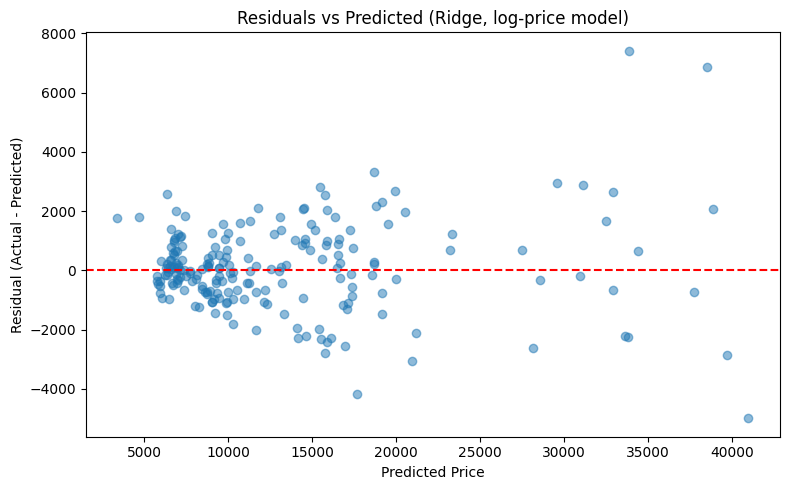

In [4]:
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_full, residuals_full, alpha=0.5)
plt.axhline(0, linestyle="--", color="red")
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted (Ridge, log-price model)")
plt.tight_layout()
plt.show()


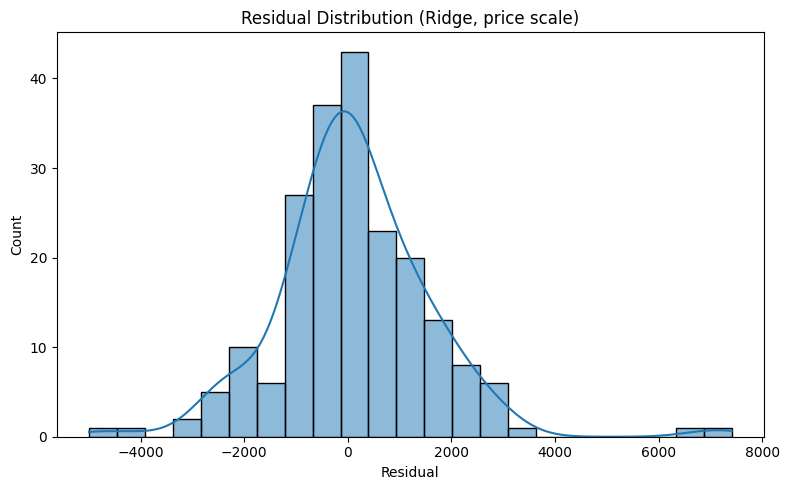

In [5]:
plt.figure(figsize=(8, 5))
sns.histplot(residuals_full, kde=True)
plt.title("Residual Distribution (Ridge, price scale)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


<Figure size 500x500 with 0 Axes>

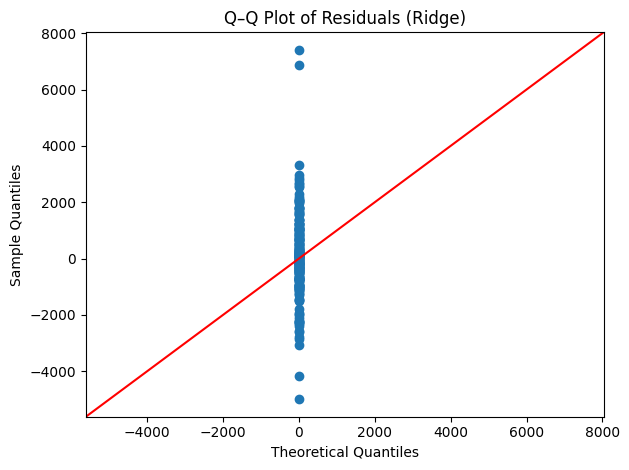

In [6]:
plt.figure(figsize=(5, 5))
sm.qqplot(residuals_full, line="45")
plt.title("Q–Q Plot of Residuals (Ridge)")
plt.tight_layout()
plt.show()


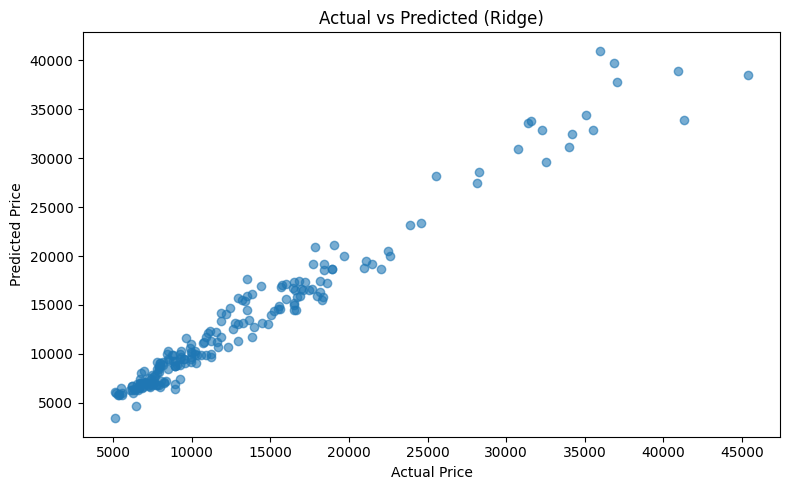

In [7]:
plt.figure(figsize=(8, 5))
plt.scatter(y, y_pred_full, alpha=0.6)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted (Ridge)")
plt.tight_layout()
plt.show()


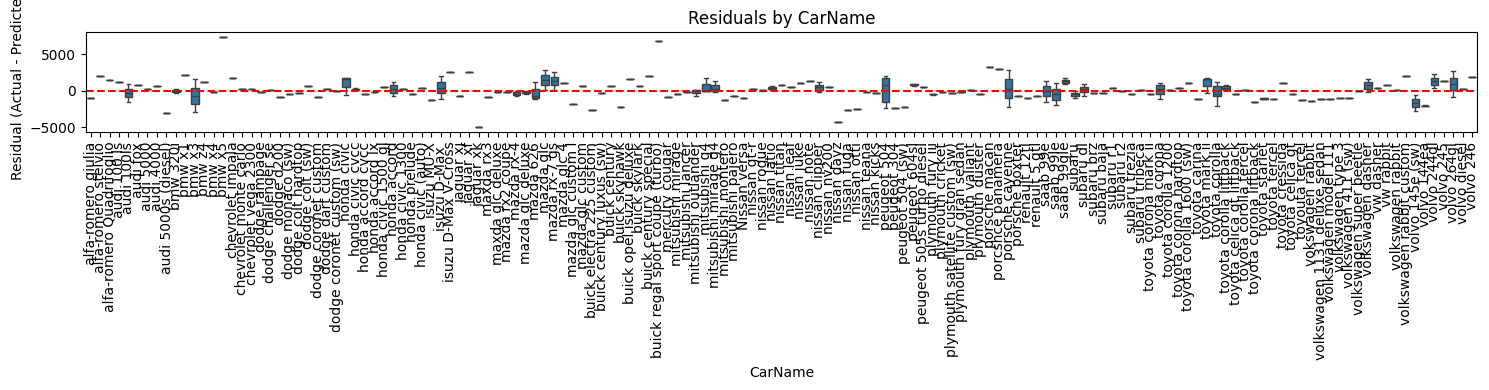

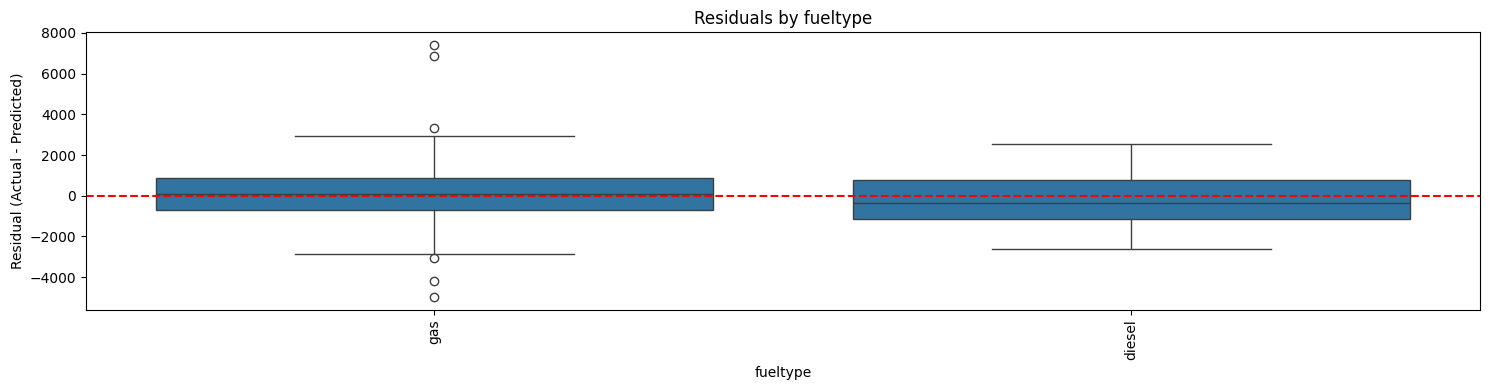

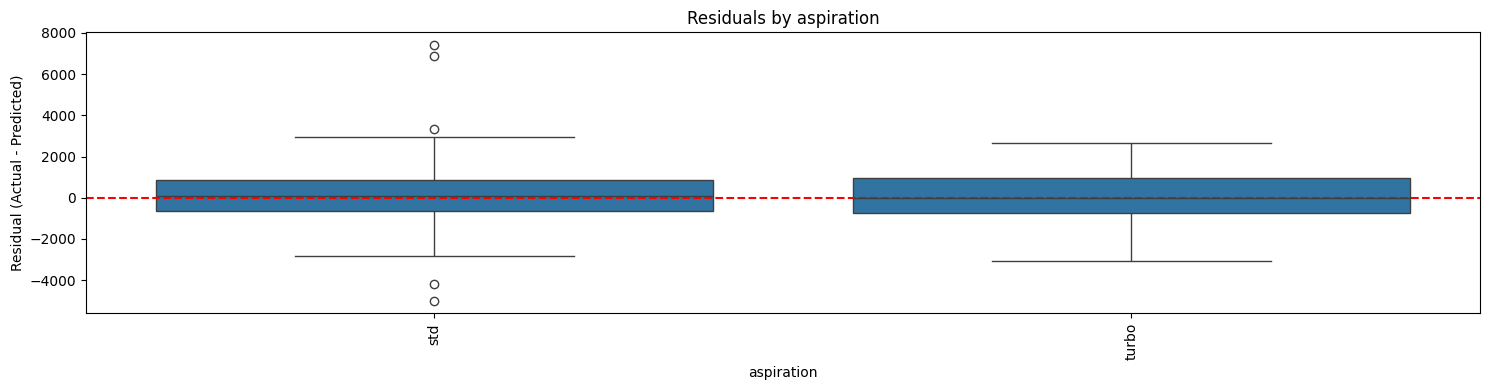

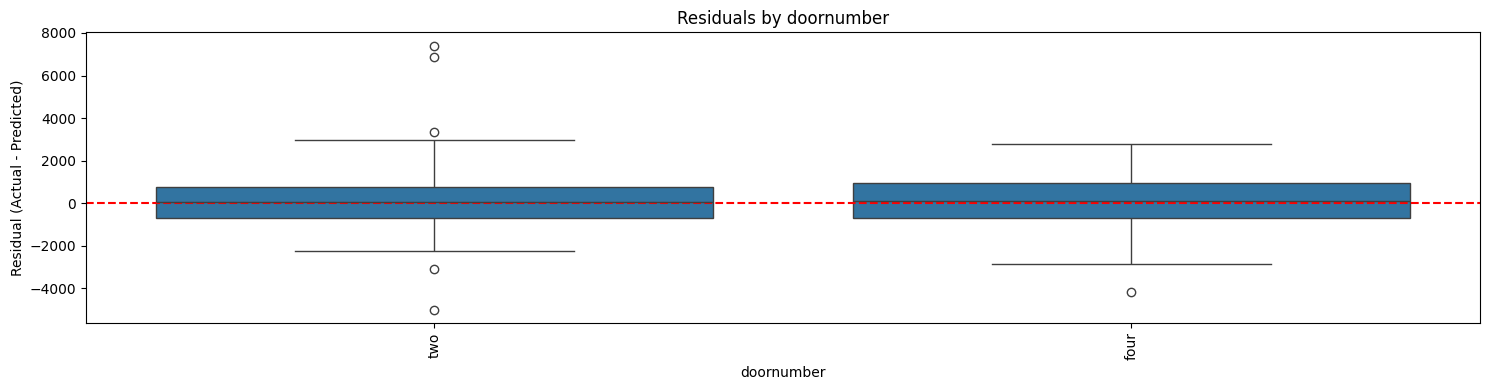

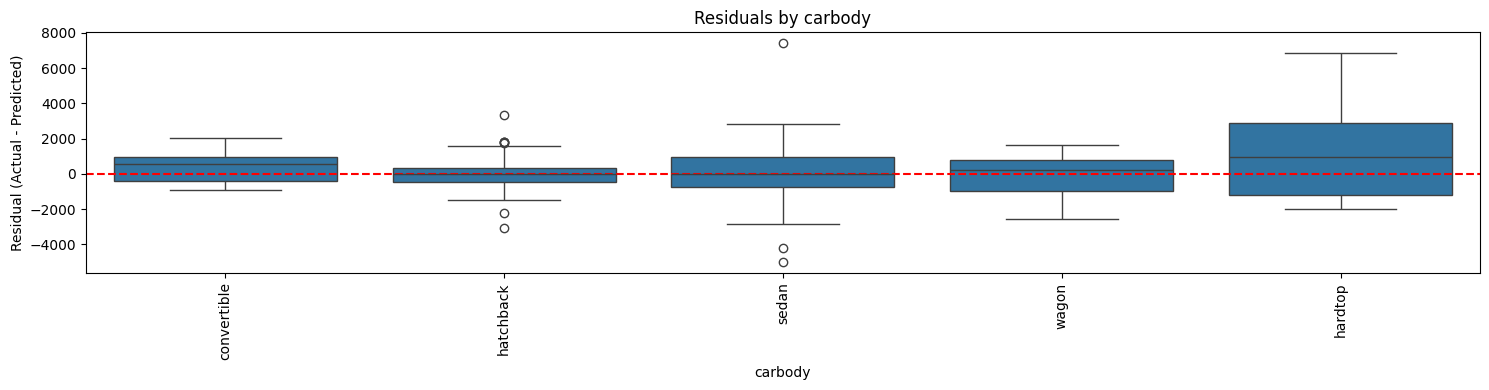

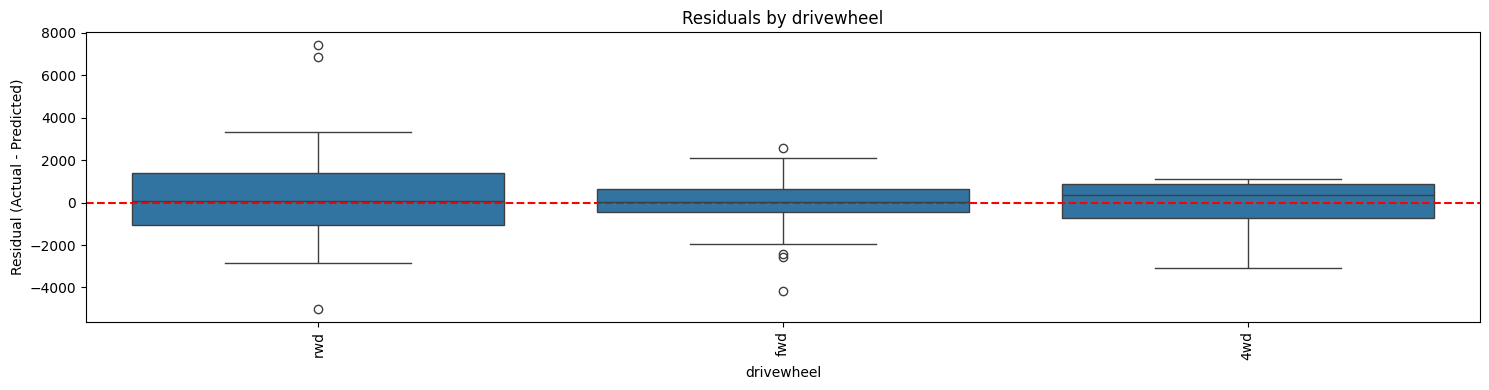

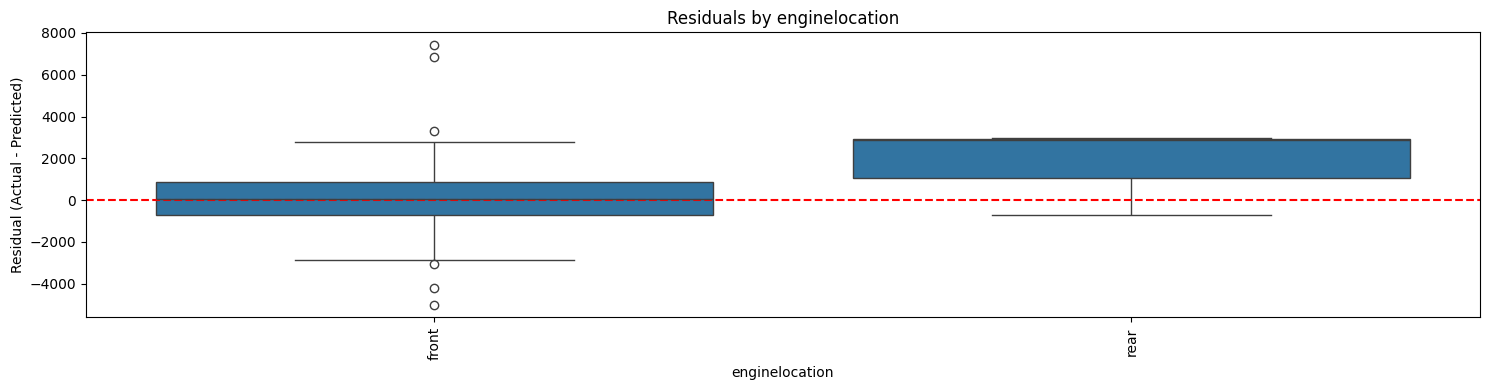

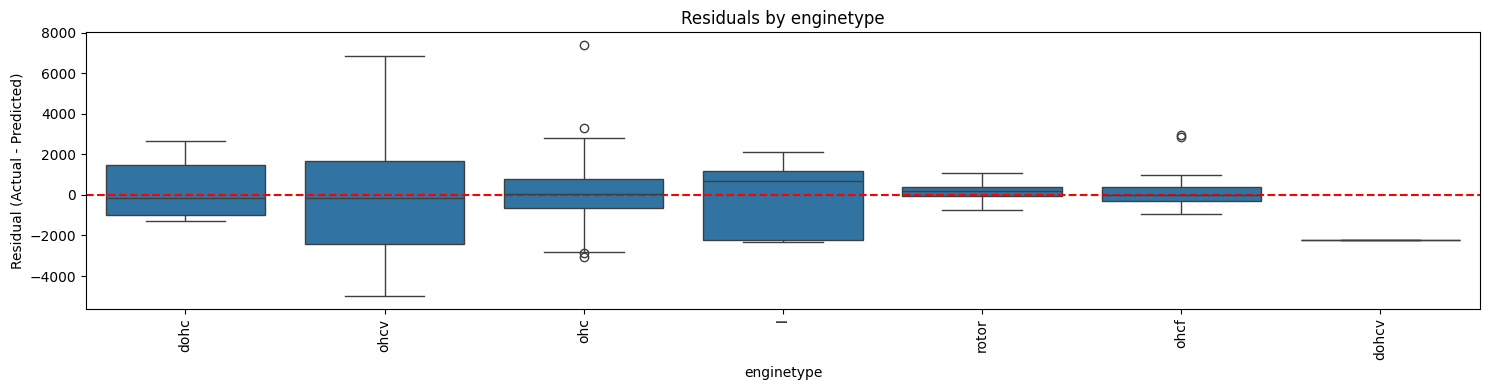

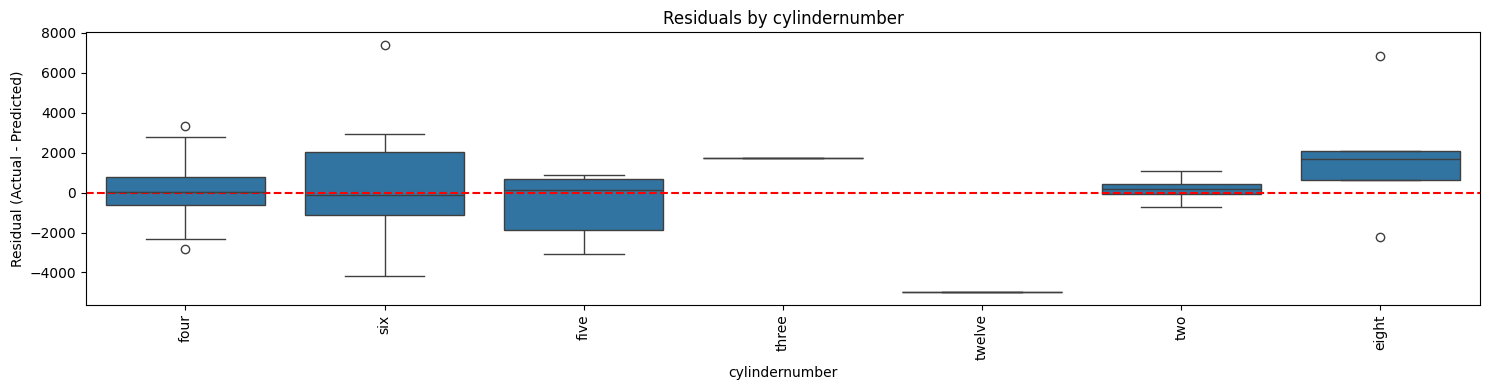

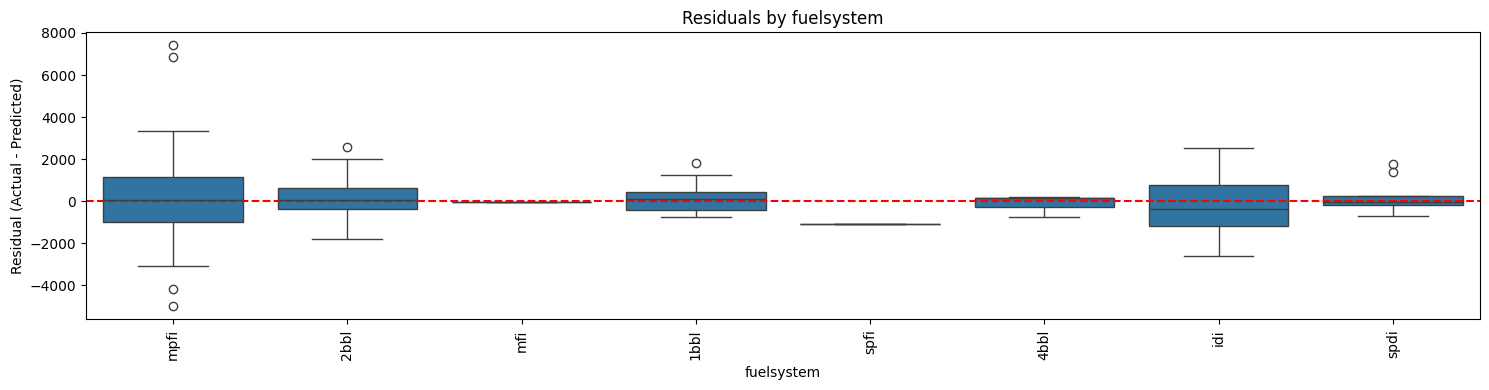

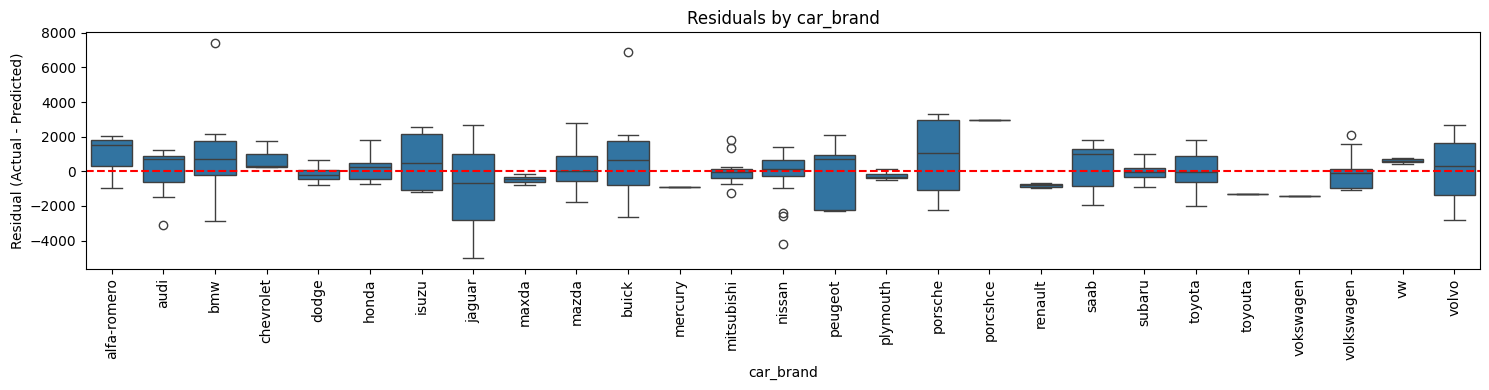

In [8]:
for col in CATEGORICAL_FEATURES[:]:  # or pick specific columns manually
    plt.figure(figsize=(15, 4))
    sns.boxplot(x=df[col], y=residuals_full)
    plt.axhline(0, linestyle="--", color="red")
    plt.title(f"Residuals by {col}")
    plt.xlabel(col)
    plt.xticks(rotation=90)
    plt.ylabel("Residual (Actual - Predicted)")
    plt.tight_layout()
    plt.show()


In [9]:
fi = get_feature_importance(pipeline)
fi.head()


,Feature,Coefficient
177,car_brand_bmw,0.374772
144,carbody_convertible,0.171846
178,car_brand_buick,0.147746
63,CarName_mazda rx-7 gs,0.138501
28,CarName_buick regal sport coupe (turbo),0.124117


In [10]:
fi["Approx_%_effect"] = (np.exp(fi["Coefficient"]) - 1) * 100
fi_sorted = fi.sort_values("Coefficient", ascending=False)

fi_sorted.head(10)


,Feature,Coefficient,Approx_%_effect
177,car_brand_bmw,0.374772,45.466000
144,carbody_convertible,0.171846,18.749474
178,car_brand_buick,0.147746,15.921871
63,CarName_mazda rx-7 gs,0.138501,14.855049
28,CarName_buick regal sport coupe (turbo),0.124117,13.214887
176,car_brand_audi,0.118112,12.536970
50,CarName_isuzu D-Max,0.105664,11.144842
96,CarName_porsche macan,0.094909,9.955865
185,car_brand_mazda,0.087286,9.120922
172,fuelsystem_mpfi,0.083277,8.684233


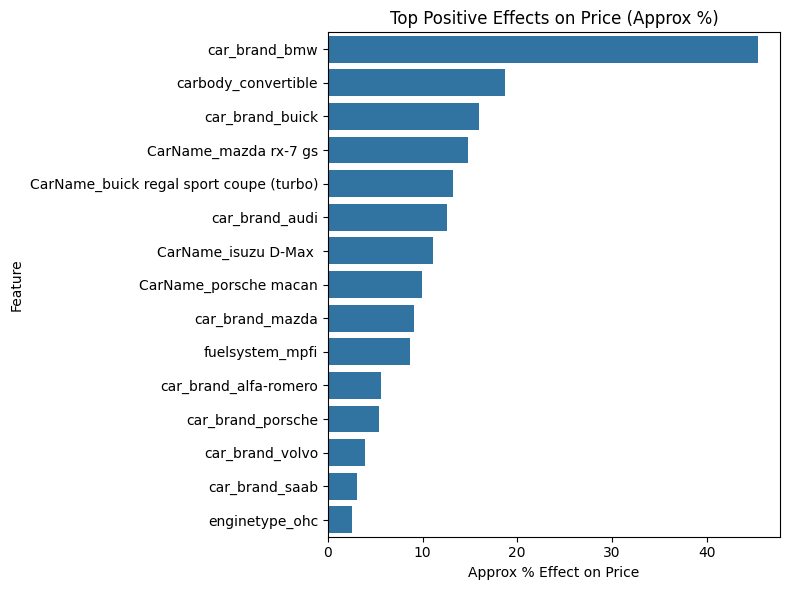

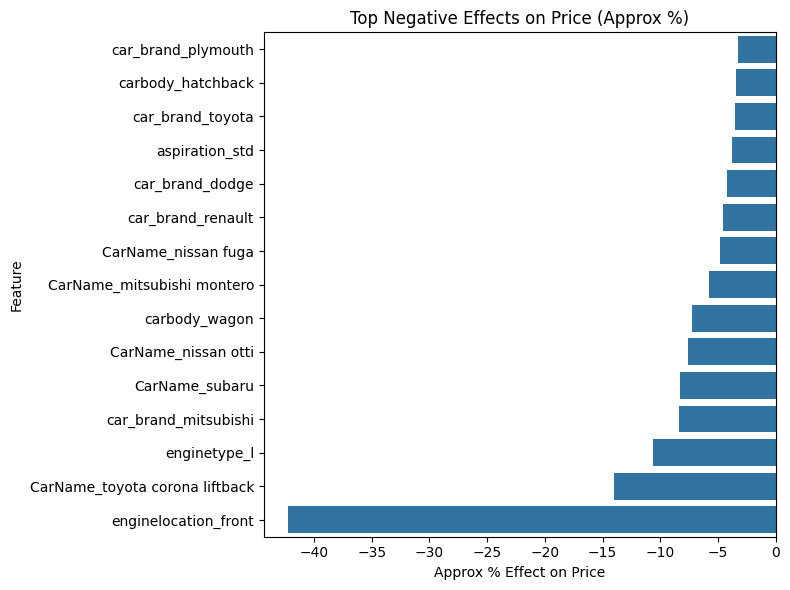

In [11]:
top_n = 15

top_pos = fi_sorted.head(top_n)
top_neg = fi_sorted.tail(top_n)

plt.figure(figsize=(8, 6))
sns.barplot(data=top_pos, x="Approx_%_effect", y="Feature")
plt.title("Top Positive Effects on Price (Approx %)")
plt.xlabel("Approx % Effect on Price")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(data=top_neg, x="Approx_%_effect", y="Feature")
plt.title("Top Negative Effects on Price (Approx %)")
plt.xlabel("Approx % Effect on Price")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [12]:
summary = {
    "n_rows": len(df),
    "n_features": X.shape[1],
    **regression_metrics(y, y_pred_full),
}
summary


{'n_rows': 205,
 'n_features': 25,
 'MAE': 1049.3932905618012,
 'MSE': 2216932.922399317,
 'RMSE': np.float64(1488.9368429853957),
 'R2': 0.9650934072399464}